<a href="https://colab.research.google.com/github/C3578/Cell_detection/blob/master/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from fastai.vision import *
import pandas as pd
import glob



In [ ]:
data_root = 'gdrive/My Drive/Colab Notebooks/'

path_images = Path('gdrive/My Drive/Colab Notebooks/train')
path_lbl = path_images
path_test = Path('gdrive/My Drive/Colab Notebooks/test')

In [ ]:
fn_list = glob.glob('gdrive/My Drive/Colab Notebooks/train/*[!_mask].tif') #создает список с именами img(x)

In [ ]:
filter_func = lambda x: str(x) in fn_list

In [ ]:
def get_y_fn(x):  # выдает y(имя маски) по x
    x = Path(x)
    return path_lbl/f'{x.stem}_mask{x.suffix}'

In [ ]:
codes = ['0','1']
src = (SegItemListCustom.from_folder(path_images)  # path_images = Path("../input/train")
       .filter_by_func(filter_func) # Сохраняет только те элементы, для которых func возвращает True.filter_func = lambda x: str(x) in fnames х 
       .split_by_rand_pct()  # Разделите элементы случайным образом, поместив valid_pct в набор проверки
       .label_from_func(get_y_fn,classes=codes))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [ ]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)  # для каждого изображения x возврвщае маску(y)
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom # метка класса для этого изображения и есть маска


In [ ]:
from fastai.utils.mem import *
size = 128
bs=16

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
data.path = Path('.')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


You can deactivate this warning by passing `no_check=True`.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/fastai/basic_data.py:248: UserWarning: Your training dataloader is empty, you have only 3 items in your training set.
                 Your batch size is 16, you should lower it.
  Your batch size is {self.train_dl.batch_size}, you should lower it.""")


In [ ]:
def dice_func(input, target):
    smooth = 0
    input = input[:,1,:,:]
    iflat = input.flatten().float()
    tflat = target.flatten().float()
    intersection = (iflat * tflat).sum()
    return ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

def dice(input:Tensor, targs:Tensor, iou:bool=False)->Rank0Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)

In [ ]:
learn = unet_learner(data, models.resnet18, metrics=[dice], wd=1e-3)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [ ]:
learn.model_dir = 'gdrive/My Drive/Colab Notebooks/models'
learn.load("stage-4", with_opt=True)

In [ ]:
img = open_image('gdrive/My Drive/Colab Notebooks/test/1.tif')

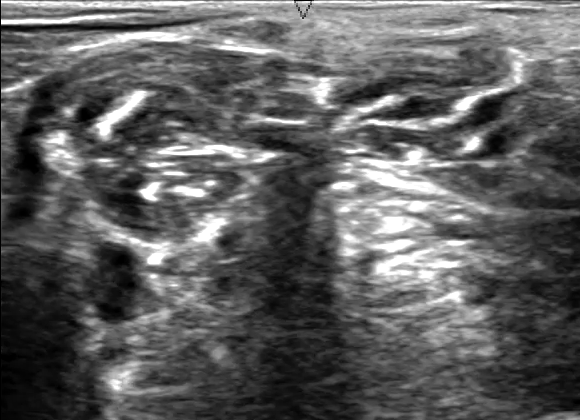

In [ ]:
img

In [ ]:
mask = learn.predict(open_image('gdrive/My Drive/Colab Notebooks/test/1.tif'))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [ ]:
len(mask)

3

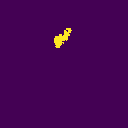

In [ ]:
mask[0]